## 1. Data Pre-processing

### 1.1 Load Data

In [ ]:
pip install fredapi

In [ ]:
pip install rich

     |████████████████████████████████| 232 kB 13.8 MB/s 
     |████████████████████████████████| 51 kB 8.1 MB/s 


In [ ]:
import pandas as pd
import numpy as np

API_KEY = '1vGb0FOsg2hEIGrEhpueLCcWd1Y'
FRED_API_KEY = 'b13a905b98b5dfc1f3910d6a0d875ae3'

rootUrl = 'https://api.glassnode.com'

symbolList = ['BTC', 'ETH', 'LTC', 'AAVE', 'ABT', 'AMPL', 'ANT', 'ARMOR', 'BADGER', 'BAL', 'BAND', 'BAT', 'BIX', 'BNT', 'BOND', 'BRD', 'BUSD', 'BZRX', 'CELR', 'CHSB', 'CND', 'COMP', 'CREAM', 'CRO', 'CRV', 'CVC', 'CVP', 'DAI', 'DDX', 'DENT', 'DGX', 'DHT', 'DMG', 'DODO', 'DOUGH', 'DRGN', 'ELF', 'ENG', 'ENJ', 'EURS', 'FET', 'FTT', 'FUN', 'GNO', 'GUSD', 'HEGIC', 'HOT', 'HPT', 'HT', 'HUSD', 'INDEX', 'KCS', 'LAMB', 'LBA', 'LDO', 'LEO', 'LINK', 'LOOM', 'LRC', 'MANA', 'MATIC',
              'MCB', 'MCO', 'MFT', 'MIR', 'MKR', 'MLN', 'MTA', 'MTL', 'MX', 'NDX', 'NEXO', 'NFTX', 'NMR', 'Nsure', 'OCEAN', 'OKB', 'OMG', 'PAY', 'PERP', 'PICKLE', 'PNK', 'PNT', 'POLY', 'POWR', 'PPT', 'QASH', 'QKC', 'QNT', 'RDN', 'REN', 'REP', 'RLC', 'ROOK', 'RPL', 'RSR', 'SAI', 'SAN', 'SNT', 'SNX', 'STAKE', 'STORJ', 'sUSD', 'SUSHI', 'TEL', 'TOP', 'UBT', 'UMA', 'UNI', 'USDC', 'USDK', 'USDP', 'USDT', 'UTK', 'VERI', 'WaBi', 'WAX', 'WBTC', 'WETH', 'wNXM', 'WTC', 'YAM', 'YFI', 'ZRX']

# symbolListShort = ['BTC', 'ETH', 'LTC']

endPoints = {
    'Price': '/v1/metrics/market/price_usd_close',
    'MarketCap': '/v1/metrics/market/marketcap_usd',
    'ActiveAddress': '/v1/metrics/addresses/active_count',
}

### 1.2 Get Multiple Attributes for Multiple Coins:

In [ ]:
def PullData(coin: str,
             feature: str):
    """This Method Pull Data According to Input Parameters(coin, feature)

    Args:
        coin (str): Name of a Coin. Like: "BTC"
        feature (str): Feature of a Coin. Like: "Price"

    Returns:
        data (pd.DataFrame): A DataFrame Contains Date and Feature of One Coin
    """
    import requests

    # Assemble full request url and get responses:
    reqUrl = rootUrl + endPoints[feature]
    res = requests.get(reqUrl,
                       params={'a': coin,
                               'api_key': API_KEY,
                               'i': '1w'})
    data_raw = pd.read_json(res.text,
                            convert_dates=['t'])

    # Rename column "v" according to features
    data = data_raw.rename(columns={"v": f"{feature}",
                                    't': 'Date'})

    # Return a dataframe
    return data

In [ ]:
def PullStart(coinList: list):
    """This Method Gets Features(Listed in "endPoints"(Constant)) of Coins(Listed in "coinList"(Method Parameter))

    Args:
        coinList (list): The List of Coins' Name

    Returns:
        fullFrame (pd.DataFrame): A DataFrame Contains All Features of Listed Coin's
    """
    # Initialization
    from functools import reduce
    from fredapi import Fred
    from rich.console import Console
    console = Console()

    colName = ["Date"]
    for key in endPoints.items():
        colName.append(key)
    fullFrame = pd.DataFrame(columns=colName.append("Asset"))

    # Show Welcome
    console.print("Loading [bold magenta]All[/bold magenta] Coins Data")

    # Pull Fred RiskFree
    fred = Fred(api_key=FRED_API_KEY)
    Risk_free_rate = fred.get_series('DGS1MO', frequency = 'wem').to_frame().reset_index().rename(columns={'index': 'Date',
                                                                                        0: 'RiskFree'})
    Risk_free_rate['RiskFree'] = Risk_free_rate['RiskFree'] / 100

    # Init Loop Count
    count = 1
    # Data Pull
    for i in coinList:
        # Preparation for merging
        frameName = f"{i}_Frames"
        locals()[frameName] = []

        # Progress Bar Init
        from rich.progress import (Progress,
                                   TextColumn, 
                                   BarColumn,
                                   TaskProgressColumn, 
                                   TimeElapsedColumn, 
                                   TimeRemainingColumn)

        progress = Progress(TextColumn("[progress.description]{task.description}"), 
                            BarColumn(), 
                            TaskProgressColumn(), 
                            TimeRemainingColumn(compact=True,
                                                elapsed_when_finished=True))
                            #expand=True)
        
        with progress:
                # Get data
            for j in progress.track(endPoints.keys(), description=f"Pulling {i}'s Data, Coins Ramaining: {len(coinList) - count}"):
                locals()[frameName].append(PullData(i,
                                                    j))
        
        # Loop Count + 1
        count += 1 

        # Merge 2-column dataframes to a single dataframe
        dfName = f"{i}_All"
        # Outer Merge Glassnode to Ensure Not Missing Any Values.
        # Left Merge Fred to ensure all the records in api stored.
        locals()[dfName] = reduce(lambda left, right:
                                  pd.merge(left, right,
                                           on='Date',
                                           how='outer'),
                                  locals()[frameName]).merge(Risk_free_rate,
                                                             how='left',
                                                             on='Date').sort_values(by=['Date'])
        locals()[dfName]['Asset'] = i

        # Merge All Coins into a single Dataframe
        fullFrame = pd.concat([fullFrame, locals()[dfName]],
                                     ignore_index=True)

        #print(f"\n{i} data successfully pulled\n")
    console.print('All Frames Merged')
    console.print('\nALL DATA [bold green]SUCCESSFULLY[/bold green] PULLED!')

    return fullFrame

### 1.3 Imputation for NA values using linear interpolation method

If the price for the asset is missing for the latest 4 weeks , then we consider it as a cryto currency that stopped trading, we won't include it in our sample. (this should be done before return calculation)

In [ ]:
def InterpolationImpute(sample: pd.DataFrame):
    """This Method will impute NA values using linear interpolation method

    Args:
        sample (pd.DataFrame): The Pulled Data 

    Returns:
        fullFrame (pd.DataFrame): A DataFrame Imputed all NA using linear interpolation
    """
    # Initialization
    imputedFrame = pd.DataFrame(columns=list(sample.columns))

    orgcols = list(sample.columns)
    cols = orgcols.copy()
    cols.remove('Date')
    cols.remove('Asset')
    for index in sample['Asset'].unique().tolist():
        syntax = f"Asset == '{index}'"
        segment = sample.query(syntax)

#if the price for the asset is missing for the latest **4 weeks** ,
#then we consider it as a cryto currency that stopped trading, we won't include it in our sample

        if (segment['Price'][-4:].isnull().sum() < 4):
            temp = segment[cols].interpolate(
                method='linear', limit_direction='forward', axis=0)
            temp['Asset'] = segment['Asset']
            temp['Date'] = segment['Date']
            imputedFrame = pd.concat([imputedFrame, temp[orgcols]],
                                     ignore_index=True)

    return imputedFrame

### <font color = red> 1.4 Calculate Returns (to be changed)

In [ ]:
def AddReturn(sample: pd.DataFrame):
    """This Method Add Return Column to Pulled Raw Data

    Args:
        sample (pd.DataFrame): The Raw Pulled Data without a Return Column

    Returns:
        fullFrame (pd.DataFrame): DataFrame with a Return Column
    """
    fullFrame = pd.DataFrame(columns=list(sample.columns).append(['Return','week2_return','Npast52']))
    for index in sample['Asset'].unique().tolist():
        syntax = f"Asset == '{index}'"
        segment = sample.query(syntax)
        # Only Select 53 Weeks for Test
#         temp = segment[-53:-1].reset_index().drop('index', axis=1)
#         segment = segment[-52:].reset_index().drop('index', axis=1)
        segment = segment.assign(Return = segment.Price.rolling(2).apply(lambda x: (x.iloc[-1]-x.iloc[0])/x.iloc[0]).copy())
        segment = segment.assign(week2_return = segment.Price.rolling(4).apply(lambda x: (x.iloc[-2]-x.iloc[0])/x.iloc[0]))
        segment = segment.assign(Npast52_return = segment.Price.rolling(52).apply(lambda x: (x.iloc[-1]-x.iloc[0])/x.iloc[0]))
        segment = segment[-52:].reset_index(drop=True)
        fullFrame = pd.concat([fullFrame, segment],
                                     ignore_index=True)
        fullFrame["ExcessReturn"] = fullFrame["Return"] - fullFrame["RiskFree"]

    return fullFrame

### 1.5 Initialize 

In [ ]:
# Get fullSample Raw Data(Without Return)
fullSample_raw = PullStart(symbolList)

Loading All Coins Data

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

All Frames Merged

ALL DATA SUCCESSFULLY PULLED!

In [ ]:
# Impute missing value using interploration method
imputedfullSample = InterpolationImpute(fullSample_raw)
imputedfullSample

,Date,Price,MarketCap,ActiveAddress,RiskFree,Asset
0,2008-12-29,NaN,NaN,0.0,0.0002,BTC
1,2009-01-05,NaN,NaN,0.0,0.0008,BTC
2,2009-01-12,NaN,NaN,34.0,0.0004,BTC
3,2009-01-19,NaN,NaN,63.0,0.0004,BTC
4,2009-01-26,NaN,NaN,61.0,0.0003,BTC
...,...,...,...,...,...,...
22742,2022-03-28,0.910632,7.717570e+08,835.0,0.0017,ZRX
22743,2022-04-04,0.754619,6.395366e+08,1284.0,0.0017,ZRX
22744,2022-04-11,0.686854,5.821057e+08,1266.0,0.0020,ZRX
22745,2022-04-18,0.808817,6.854696e+08,2274.0,0.0031,ZRX


In [ ]:
# Add Return to fullSample
fullSample = AddReturn(imputedfullSample)

### 1.6 Get the large capitalization portfolio - largeCapSample 
Use (maket cap > 1m and top 100) to set up the dynamic porfolio for each week, we would use this dynamic portfolio for our factors calculation.

In [ ]:
largeCapport = fullSample.query("MarketCap > 1000000")
largeCapSample = largeCapport.groupby(['Date']).apply(lambda x: x.nlargest(100,['MarketCap'])).reset_index(drop=True)

## 2. MKT Factor (Fiona)

### 2.1 Calculate MKT for each week

In [ ]:
## largeCapSample is a big dataframe include all crypto currencies makcap greater than 1000000
marketport = largeCapSample.groupby('Date')['MarketCap'].sum().reset_index(name='TotalMarketCap')

marketInd = largeCapSample.copy()
marketInd['weights'] = marketInd['Return'] * marketInd['MarketCap']
recomp = marketInd.groupby('Date')['weights'].sum().reset_index(name='TotalMarketReturn')
marketport['MarketIndexReturn'] = recomp['TotalMarketReturn']/ marketport['TotalMarketCap']

In [ ]:
riskfree = largeCapSample.groupby('Date')['RiskFree'].mean().reset_index()
marketport = marketport.merge(riskfree, on='Date')
marketport['MKT'] = marketport['MarketIndexReturn'] - marketport['RiskFree']
MKT_f = marketport[['Date','MKT']]

### 2.2 MKT_f - market factor

In [ ]:
MKT_f.head()

,Date,MKT
0,2021-05-03,0.118404
1,2021-05-10,-0.145781
2,2021-05-17,-0.280499
3,2021-05-24,0.069525
4,2021-05-31,0.042021


### <font color='green'> Test for mkt factor
    value weighted return= weight1 * return1 + weight2 * return 2 + ...
    weight1 = cap1/cap_sum,  weight2 = cap2/cap_sum ...
    value weighted return = cap1  * return1/cap_sum  + cap2 * return2/cap_sum + ..
                          = (cap1 * return1 + cap2 * return2 + ...)/cap_sum

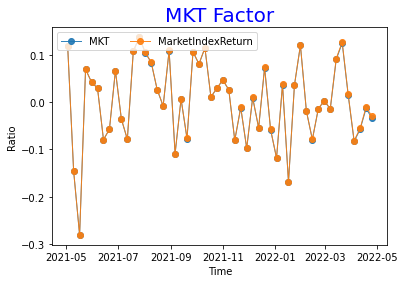

In [ ]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
%matplotlib inline

factors = marketport[["Date", "MKT","MarketIndexReturn"]]

palette = plt.get_cmap('Set1')
 
num=0
for column in factors.drop('Date', axis=1):
    num+=1
    plt.plot(factors['Date'], factors[column], marker='o', linewidth=1, alpha=0.9, label=column)


plt.legend(loc=2, ncol=2)
plt.title("MKT Factor", loc='center', fontsize=20, fontweight=0, color='blue')
plt.xlabel("Time")
plt.ylabel("Ratio")
plt.show()

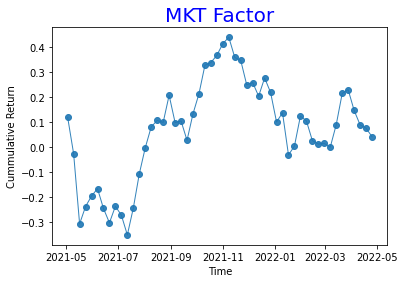

In [ ]:
plt.plot(MKT_f.Date, np.cumsum(MKT_f.MKT), marker='o', linewidth=1, alpha=0.9, label=column)
plt.title("MKT Factor", loc='center', fontsize=20, fontweight=0, color='blue')
plt.xlabel("Time")
plt.ylabel("Cummulative Return")
plt.show()

## 3. SMB Factor (Fiona)

### 3.1 Using quantile method to get the dynamic portfolios for top cap 20%, and bottom cap 20% 

In [ ]:
largeCap = largeCapSample.groupby(['Date']).apply(lambda 
                                                x: x.nlargest(round(0.2*len(x)),
                                                              ['MarketCap'])).reset_index(drop=True)

smallCap = largeCapSample.groupby(['Date']).apply(lambda 
                                                x: x.nsmallest(round(0.2*len(x)),
                                                              ['MarketCap'])).reset_index(drop=True)
largeCap.head()

,Date,Price,MarketCap,ActiveAddress,RiskFree,Asset,Return,week2_return,Npast52_return,ExcessReturn
0,2021-05-03,58218.566077,1.088991e+12,6622607.0,0.0001,BTC,0.028357,0.008014,5.020518,0.028257
1,2021-05-03,3932.359246,4.554030e+11,3548128.0,0.0001,ETH,0.331870,0.322830,17.982967,0.331770
2,2021-05-03,1.000026,5.372178e+10,576798.0,0.0001,USDT,0.000035,0.000088,-0.002087,-0.000065
3,2021-05-03,385.704466,2.608153e+10,1438322.0,0.0001,LTC,0.433524,-0.015384,7.838155,0.433424
4,2021-05-03,52.096533,2.182895e+10,65705.0,0.0001,LINK,0.320233,0.015018,12.766384,0.320133


### 3.2 Using equal-weighted average method to get the SMB
SMB = equal-weighted average of returns on small portfolis - equal-weighted average of returns on large portfolis

In [ ]:
largeport = largeCap.groupby('Date')['Return'].mean().reset_index(name='LargePortReturn')
smallport = smallCap.groupby('Date')['Return'].mean().reset_index(name='SmallPortReturn')
smallport['SMB'] = smallport['SmallPortReturn'] - largeport['LargePortReturn']
SMB_f = smallport[['Date','SMB']]

In [ ]:
SMB_f.head()

,Date,SMB
0,2021-05-03,-0.143667
1,2021-05-10,-0.189053
2,2021-05-17,-0.148497
3,2021-05-24,0.004411
4,2021-05-31,0.029201


### <font color = 'green'> Test SMB

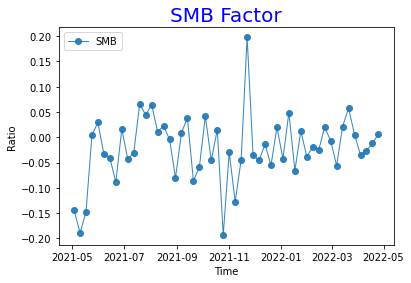

In [ ]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
%matplotlib inline

factors = SMB_f

palette = plt.get_cmap('Set1')
 
num=0
for column in factors.drop('Date', axis=1):
    num+=1
    plt.plot(factors['Date'], factors[column], marker='o', linewidth=1, alpha=0.9, label=column)


plt.legend(loc=2, ncol=2)
plt.title("SMB Factor", loc='center', fontsize=20, fontweight=0, color='blue')
plt.xlabel("Time")
plt.ylabel("Ratio")
plt.show()

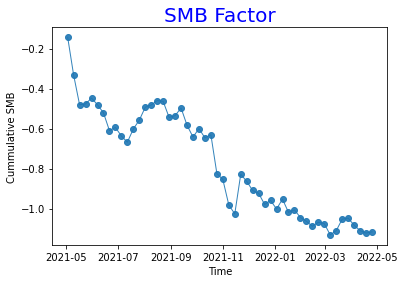

In [ ]:
plt.plot(SMB_f.Date, np.cumsum(SMB_f.SMB), marker='o', linewidth=1, alpha=0.9, label=column)
plt.title("SMB Factor", loc='center', fontsize=20, fontweight=0, color='blue')
plt.xlabel("Time")
plt.ylabel("Cummulative SMB")
plt.show()

In [ ]:
from sklearn.linear_model import LinearRegression
performance = {}


factors = SMB_f

features = factors.columns.tolist()
features.remove('Date')
target = "ExcessReturn"

for index in fullSample['Asset'].unique().tolist():
    syntax = f"Asset == '{index}'"
    segment = fullSample.query(syntax)
    
    reg = segment[['Date','ExcessReturn']].merge(factors, on = 'Date', how = 'outer')
    y = reg [target].copy()
    x = reg [features].copy()    
    model = LinearRegression()
    model.fit(x, y)
    y_pred = model.predict(x)    
    alpha = model.intercept_    
    performance[index] = alpha

In [ ]:
alp_sig = pd.DataFrame(list(performance.items()), 
                       columns = ['Asset','Alpha'])
alp_sig = alp_sig.sort_values(by=['Alpha'], 
                              ascending = False)
alp_sig.head(10)

,Asset,Alpha
15,BRD,0.195732
112,VERI,0.083878
71,NFTX,0.082342
5,AMPL,0.064211
54,LDO,0.053610
68,MX,0.044315
28,DDX,0.041852
58,LRC,0.041307
87,QNT,0.040772
93,RPL,0.039205


In [ ]:
alp_sig.tail(10)

,Asset,Alpha
32,DMG,-0.014985
14,BOND,-0.015631
63,MIR,-0.018728
118,YAM,-0.020562
31,DHT,-0.021591
34,DOUGH,-0.021652
52,LAMB,-0.022139
20,CND,-0.024242
73,Nsure,-0.026052
7,ARMOR,-0.037581


In [ ]:
al = alp_sig.head(10).Asset.tolist()
hi = fullSample.query("Asset in @al ")

mk = hi.groupby('Asset')['MarketCap'].mean().reset_index(name = "AverageMarketCap")
mk

,Asset,AverageMarketCap
0,AMPL,1.445432e+08
1,BRD,2.657980e+07
2,DDX,1.063225e+08
3,LDO,1.300025e+08
4,LRC,1.195700e+09
5,MX,2.055389e+08
6,NFTX,5.288922e+07
7,QNT,1.950075e+09
8,RPL,2.945992e+08
9,VERI,1.018901e+08


In [ ]:
asm = alp_sig.tail(10).Asset.tolist()
lo = fullSample.query("Asset in @asm ")

ml = lo.groupby('Asset')['MarketCap'].mean().reset_index(name = "AverageMarketCap")
ml

,Asset,AverageMarketCap
0,ARMOR,1.743356e+07
1,BOND,3.827531e+09
2,CND,2.369338e+07
3,DHT,1.481919e+07
4,DMG,2.217906e+06
5,DOUGH,5.848372e+06
6,LAMB,2.159385e+07
7,MIR,2.226654e+08
8,Nsure,1.129428e+06
9,YAM,3.947659e+06


## 4. VAL Factor (Lydia)

**4.1 Reshape to get three tables with: Npast52_return, MarketCap, Return**

In [ ]:
value_npast52 = fullSample.loc[:,['Date', 
                                  'Npast52_return', 
                                  'Asset']].pivot(index="Date", 
                                                  columns=["Asset"], 

                                                  values='Npast52_return').reset_index().rename_axis(None, 
                                                                                                     axis=1).sort_values('Date')
#value_npast52.to_csv('value_npast52.csv')
#value_npast52.head()

In [ ]:
value_marketcap = fullSample.loc[:,['Date',
                                    'MarketCap',
                                    'Asset']].pivot(index ='Date', 
                                                    columns = ["Asset"],
                                                    values = 'MarketCap'). reset_index().rename_axis(None,
                                                                                                    axis=1).sort_values('Date')
#value_marketcap.head(3)

value_weekreturn = fullSample.loc[:, ['Date',
                                      'Return',
                                      'Asset']].pivot(index='Date',
                                                      columns=['Asset'],
                                                      values ='Return').reset_index().rename_axis(None,
                                                                                                  axis=1).sort_values('Date')
                                                                                   
#value_weekreturn.head(3)

**4.2 Generate two tables to identify whether in a day a coins is top20 or low20 against Npast52:**

In [ ]:
value_npast52_temp = value_npast52.copy()
cols_coins = list(fullSample['Asset'].unique())

value_npast52_temp['top20'] = value_npast52[cols_coins].quantile(q=0.8, axis=1, numeric_only=True, interpolation='linear')
value_npast52_temp['low20'] = value_npast52[cols_coins].quantile(q=0.2, axis=1, numeric_only=True, interpolation='linear')

value_npast52_top = value_npast52_temp.drop(columns =['Date','low20'])
value_npast52_low = value_npast52_temp.drop(columns =['Date','top20'])

index_top = value_npast52_top.apply(lambda x: x > value_npast52_top.iloc[:,-1])
index_top = index_top.drop(columns='top20')
index_low = value_npast52_low.apply(lambda x: x < value_npast52_low.iloc[:,-1])
index_low = index_low.drop(columns='low20')
index_low.tail()

,AAVE,ABT,AMPL,ANT,ARMOR,BADGER,BAL,BAND,BAT,BIX,...,VERI,WBTC,WETH,WTC,WaBi,YAM,YFI,ZRX,sUSD,wNXM
47,False,False,False,False,True,False,False,False,False,True,...,False,False,False,False,True,True,False,False,False,False
48,False,False,False,False,True,False,False,True,False,True,...,False,False,False,False,True,True,False,False,False,False
49,False,False,False,False,True,False,False,True,False,False,...,False,False,False,False,False,True,False,False,False,False
50,False,False,False,False,True,False,False,False,False,True,...,False,False,False,False,True,True,False,False,False,False
51,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,True,True,False,False,False,False


**4.3 Calculate top20 and low20 weighted weekly return:**

In [ ]:
sum_top_weight = pd.DataFrame((value_weekreturn.iloc[:,1:].values 
                               * index_top.values 
                               * value_marketcap.iloc[:,1:].values))
sum_top_weight['weight_top_sum'] = sum_top_weight.sum(axis='columns')


sum_top_mktcap_temp = pd.DataFrame((index_top.values 
                               * value_marketcap.iloc[:,1:].values))
sum_top_weight['Totalmktcap_top'] = sum_top_mktcap_temp.sum(axis='columns')
sum_top_weight['ValFactor_top'] = sum_top_weight['weight_top_sum'] / sum_top_weight['Totalmktcap_top']

In [ ]:
sum_low_weight = pd.DataFrame((value_weekreturn.iloc[:,1:].values 
                               * index_low.values 
                               * value_marketcap.iloc[:,1:].values))
sum_low_weight['weight_low_sum'] = sum_low_weight.sum(axis='columns')

sum_low_mktcap_temp = pd.DataFrame((index_low.values 
                               * value_marketcap.iloc[:,1:].values))
sum_low_weight['Totalmktcap_low'] = sum_low_mktcap_temp.sum(axis='columns')
sum_low_weight['ValFactor_low'] = sum_low_weight['weight_low_sum'] / sum_low_weight['Totalmktcap_low']

**4.4 Get Value Factor:**

In [ ]:
valueFactor = pd.DataFrame(columns=['Date','VAL'])
valueFactor['Date'] = value_weekreturn['Date']
valueFactor['VAL'] = sum_top_weight['ValFactor_top'] - sum_low_weight['ValFactor_low']
valueFactor

,Date,VAL
0,2021-05-03,0.427391
1,2021-05-10,0.165418
2,2021-05-17,-0.409644
3,2021-05-24,0.149525
4,2021-05-31,0.121057
5,2021-06-07,-0.068965
6,2021-06-14,-0.099015
7,2021-06-21,-0.122532
8,2021-06-28,0.164612
9,2021-07-05,-0.073297


**4.5 Factor visualization:**

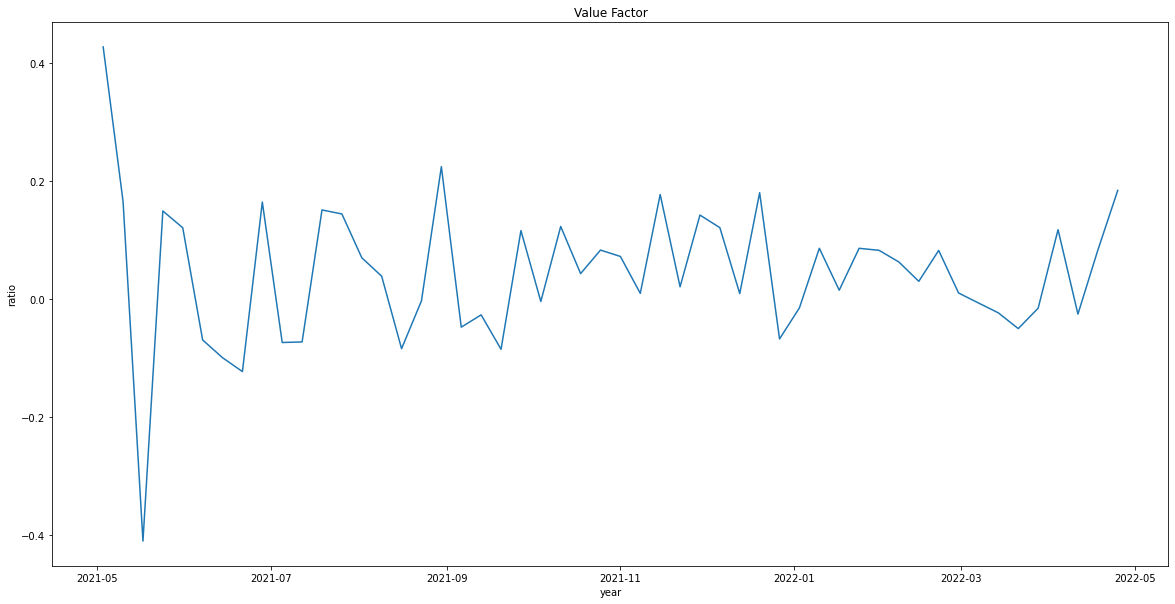

In [ ]:
import matplotlib.pyplot as plt

#for i in regr_df.columns.to_list():
plt.figure(figsize = (20,10))
plt.plot(valueFactor.Date, valueFactor.VAL)
plt.ylabel('ratio')
plt.xlabel('year')
plt.title('Value Factor')
plt.show()


## 5. MOM Factor (Sean)

In [ ]:
def getMomFactor(largeCapSample: pd.DataFrame):
    """This Method Returns Momentum Factor

    Args:
        largeCapSample (pd.DataFrame): Large Cap Sample

    Returns:
        momFactor (pd.DataFrame): Contains Momentum Factor
    """
    # Pivot largeCapSample to Get Return Matrix
    returnAll = largeCapSample.loc[:, ['Date',
                                   'Return',
                                       'Asset']].pivot(index="Date",
                                                       columns=["Asset"],
                                                       values='Return').reset_index().rename_axis(None,
                                                                                                  axis=1).sort_values('Date')
    
    # Pivot largeCapSample to Get Momentum Matrix(Past 2-Week Returns)
    momMatrix = largeCapSample.loc[:, ['Date',
                                       'week2_return',
                                       'Asset']].pivot(index="Date",
                                                       columns=["Asset"],
                                                       values='week2_return').reset_index().rename_axis(None,
                                                                                                        axis=1).sort_values('Date')

    # Calculate the Momentum Percentile
    col = []
    for colName in momMatrix.columns:
        if colName not in ['Date']:
            col.append(colName)
    momMatrix[col].head()

    momPt = pd.DataFrame(columns=['MOM20p',
                                  'MOM80p'])

    momPt['MOM20p'] = momMatrix[col].quantile(.2, axis=1)
    momPt['MOM80p'] = momMatrix[col].quantile(.8, axis=1)

    # Calculate MOM Factor
    MOM = pd.DataFrame({'Date': []})
    MOM['Date'] = returnAll.Date
    MOM['HighMomentum'] = returnAll[momMatrix[largeCapSample.Asset.unique()].apply(
        lambda x: x >= momPt['MOM80p'])].mean(axis=1, numeric_only=True)
    MOM['LowMomentum'] = returnAll[momMatrix[largeCapSample.Asset.unique()].apply(
        lambda x: x <= momPt['MOM20p'])].mean(axis=1, numeric_only=True)
    MOM['MOM'] = MOM.HighMomentum - MOM.LowMomentum
    momFactor = MOM.drop(columns=['HighMomentum', 'LowMomentum'])
    return momFactor


Text(0, 0.5, 'Cumulative Return')

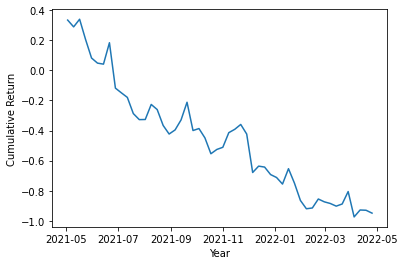

In [ ]:
momFactor = getMomFactor(largeCapSample)

import matplotlib.pyplot as plt

plt.plot(momFactor.Date, np.cumsum(momFactor.MOM))
plt.xlabel('Year')
plt.ylabel('Cumulative Return')

## 6. NET Factor (Zachary)

The network factor (NET) is constructed by splitting the coins of the Core Sample into 3 groups due to the limitation of available coins. Particularly, each week we split the cryptocurrencies into three [30% 40% 30%] groups by the growth rate in total addresses with balance. The network factor (NET) is the return difference between the top and the bottom network portfolios. 

### Get Address Growth

In [ ]:
Address = largeCapSample.loc[:,['Date', 'ActiveAddress', 'Asset']] \
                    .pivot(index = 'Date', columns = 'Asset', values = 'ActiveAddress')\
                    .reset_index() \
                    .rename_axis(None, axis = 1)

copy1 = Address.copy()
copy2 = copy1.shift()

Growth = copy1.copy()
for i in largeCapSample.Asset.unique():
    Growth[i] = np.log(copy1[i]) - np.log(copy2[i])

Growth['20Percentile'] = Growth.quantile(q=0.2, numeric_only = True, axis = 1)
Growth['80Percentile'] = Growth.quantile(q=0.8, numeric_only = True, axis = 1)

/usr/local/lib/python3.7/dist-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


### Construct Network factor

In [ ]:
Return = fullSample.loc[:,['Date', 'Return', 'Asset']] \
                    .pivot(index = 'Date', columns = 'Asset', values = 'Return')\
                    .reset_index() \
                    .rename_axis(None, axis = 1)

Marketcap = fullSample.loc[:,['Date', 'MarketCap', 'Asset']] \
                    .pivot(index = 'Date', columns = 'Asset', values = 'MarketCap')\
                    .reset_index() \
                    .rename_axis(None, axis = 1)

weight = Marketcap.copy()
weight['total_weight'] = Marketcap.sum(axis = 1, numeric_only=True)
weight[fullSample.Asset.unique()] = weight[fullSample.Asset.unique()].apply(lambda x: x/weight['total_weight'])
weight.drop(columns=['total_weight'])

Weighted_Return = Return.copy()
for i in fullSample.Asset.unique():
    Weighted_Return[i] = weight[i] * Return[i]

In [ ]:
Return = largeCapSample.loc[:,['Date', 'Return', 'Asset']] \
                    .pivot(index = 'Date', columns = 'Asset', values = 'Return')\
                    .reset_index() \
                    .rename_axis(None, axis = 1)

NET = pd.DataFrame({'Date':[]})
NET['Date'] = Return.Date
NET['long'] = Return[Growth[largeCapSample.Asset.unique()].apply(lambda x: x >= Growth['80Percentile'])].mean(axis=1, numeric_only= True)
NET['short'] = Return[Growth[largeCapSample.Asset.unique()].apply(lambda x: x <= Growth['20Percentile'])].mean(axis=1, numeric_only= True)
NET.fillna(value = 0, inplace=True)
NET['NET'] = NET.long - NET.short
NET.drop(columns=['short', 'long'], inplace=True)

### Verification

Text(0, 0.5, 'Cumulative Return')

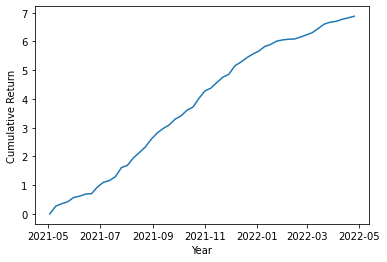

In [ ]:
import matplotlib.pyplot as plt

plt.plot(NET.Date, np.cumsum(NET.NET))
plt.xlabel('Year')
plt.ylabel('Cumulative Return')

## 7.Regression Output
### 7.1 Output a list of alphas for all the crypto currencies using factors
Note: Only pick the top 100 cypto currencies from the latest week and check their alphas.

In [81]:
factorList = [MKT_f, SMB_f, valueFactor, momFactor, NET]
def ModelBuild(fullSample,
               factorList):
    from sklearn.linear_model import LinearRegression

    largeCapSample = fullSample.query("MarketCap > 1000000").groupby(['Date']).apply(lambda x: x.nlargest(100,['MarketCap'])).reset_index(drop=True)

    performance = {}

    ## find the top 100 cypto currencies at the last week

    latest = largeCapSample.Date.max()
    latestLarge = largeCapSample.query("Date == @latest")

    # factors = factors.merge(MOM_f, on = 'Date', how ='outer')
    from functools import reduce
    factors = reduce(lambda left, right:
                    pd.merge(left, 
                            right,
                            on='Date',
                            how='outer'),
                    factorList)

    features = factors.columns.tolist()
    features.remove('Date')
    target = "ExcessReturn"

    for index in latestLarge['Asset'].tolist():
        syntax = f"Asset == '{index}'"
        segment = fullSample.query(syntax)
        
        reg = segment[['Date','ExcessReturn']].merge(factors, on = 'Date', how = 'outer')
        y = reg [target].copy()
        x = reg [features].copy()    
        model = LinearRegression()
        model.fit(x, y)
        y_pred = model.predict(x)    
        alpha = model.intercept_    
        performance[index] = alpha
    alp_sig = pd.DataFrame(list(performance.items()), 
                       columns = ['Asset','Alpha'])
    alp_sig = alp_sig.sort_values(by=['Alpha'], 
                                ascending = False)
    return alp_sig

In [82]:
Alphas = ModelBuild(fullSample, factorList)
Alphas.head(10)

,Asset,Alpha
72,AMPL,0.114749
46,TEL,0.087016
92,SAN,0.056312
27,LDO,0.031673
32,GNO,0.017564
60,REP,0.016736
64,FUN,0.014910
69,BADGER,0.011615
0,BTC,0.007376
5,WBTC,0.007267


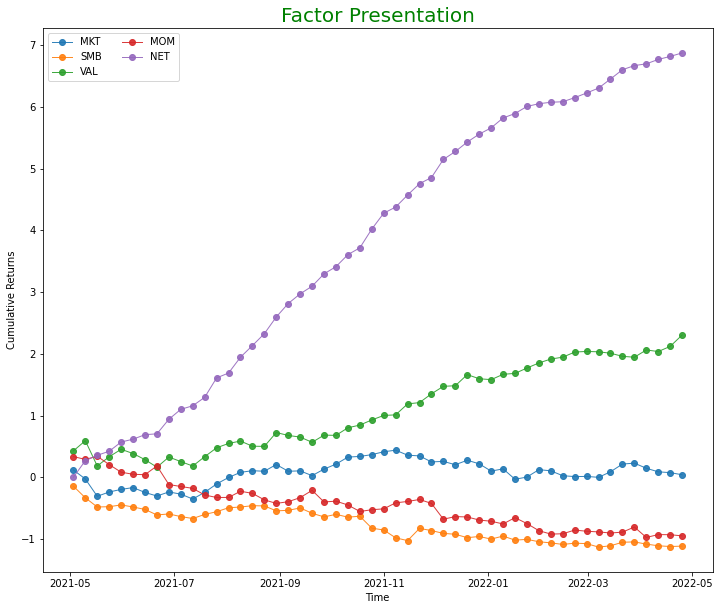

In [80]:
from functools import reduce
factors = reduce(lambda left, right:
                pd.merge(left, 
                        right,
                        on='Date',
                        how='outer'),
                factorList)

from matplotlib.pyplot import figure

plt.figure(figsize=(12,10))

palette = plt.get_cmap('Set1')
 
num=0
for column in factors.drop('Date', axis=1):
    num+=1
    plt.plot(factors['Date'], np.cumsum(factors[column]), marker='o',  linewidth=1, alpha=0.9, label=column)


plt.legend(loc=2, ncol=2)
plt.title("Factor Presentation", loc='center', fontsize=20, fontweight=0, color='green')
plt.xlabel("Time")
plt.ylabel("Cumulative Returns")
plt.show()